## Naive Lane Lines Detection

The goal of this project is to make a pipeline that finds lane lines on the road through naive Computer Vision techniques.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


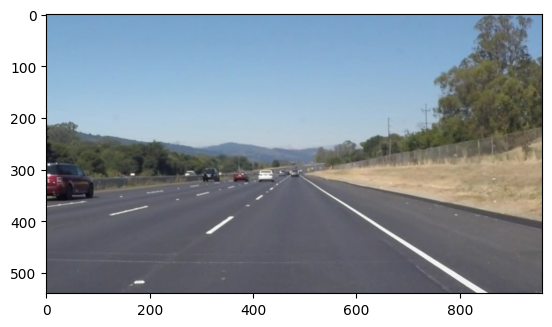

In [2]:
# Reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image



## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=2)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os

images_ip_dir = "test_images/"
image_names = os.listdir(images_ip_dir)

images_op_dir = "test_images_output/"
if not os.path.exists(images_op_dir):
    os.mkdir(images_op_dir)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# Plot image
def plot_image(img, title, subplot_pos):
    plt.subplot(*subplot_pos)
    plt.title(title)
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')

def perform_smoothing(lines_history, win_size=10):
    l,r = [0,0,0,0], [0,0,0,0]
    lines_history = np.squeeze(lines_history)  
    for idx, line in enumerate(reversed(lines_history)):
        if idx == win_size:
            break
        l += line[0]
        r += line[1]
    
    return np.int32([[l/win_size, r/win_size]])

def draw_connected_lane_lines(img, connected_lines):
    # Get a copy of the original image
    lines_img = np.copy(img)*0
    draw_lines(lines_img, connected_lines, thickness=12)
    
#     vertices = []
#     l_line, r_line = connected_lines[0][0], connected_lines[0][1]

#     vertices.append((l_line[0], l_line[1]))
#     vertices.append((l_line[2], l_line[3]))
#     vertices.append((r_line[2], l_line[3]))
#     vertices.append((r_line[0], r_line[1]))
    
#     cv2.fillPoly(lines_img, np.int32([vertices]), [0,255,0])
    
    # Perform image blending
    return weighted_img(lines_img, img)

def connect_lane_lines(lines, imshape):
    try:
        # Vectorise the lines representation
        lines = np.squeeze(lines)

        # Compute the slope and length of line segments
        m = (lines[:,3] - lines[:,1]) / (lines[:,2] - lines[:,0])
        lengths = np.sqrt((lines[:,3] - lines[:,1])**2 + (lines[:,2] - lines[:,0])**2)

        # Get rid of outliers
        mask = np.abs(m) > 0.5 
        lines, m, lengths = lines[mask], m[mask], lengths[mask]

        # Perform classification
        l_lines, r_lines = lines[m < 0, :], lines[m > 0, :] 
        l_m, r_m = m[m < 0], m[m > 0]
        l_lengths, r_lengths = lengths[m < 0], lengths[m > 0]

        # Get sorted args for the classified line segments based on their lengths
        # so we can determine the best candidates for lane detection.
        l_sorted_args, r_sorted_args = np.argsort(l_lengths), np.argsort(r_lengths)

        # Compute the slope and intercepts from the best candidates
        n = -5
        l_avgm, r_avgm = l_m[l_sorted_args][n::].mean(), r_m[r_sorted_args][n:].mean()

        l_x, l_y = np.concatenate([l_lines[:,0],l_lines[:,2]]), np.concatenate([l_lines[:,1],l_lines[:,3]])
        r_x, r_y = np.concatenate([r_lines[:,0],r_lines[:,2]]), np.concatenate([r_lines[:,1],r_lines[:,3]])

        l_b = l_y - (l_avgm * l_x)
        r_b = r_y - (r_avgm * r_x)
        l_avgb, r_avgb = l_b[l_sorted_args][n:].mean(), r_b[r_sorted_args][n:].mean()

        # Determine the L&R lane endpoints
        y1 = imshape[0]/1.5
        l_x1 = (y1 - l_avgb) / l_avgm
        y2 = imshape[0]
        l_x2 = (y2 - l_avgb) / l_avgm

        r_x1 = (y1 - r_avgb) / r_avgm
        r_x2 = (y2 - r_avgb) / r_avgm

        connected_lines = np.int32([[[l_x1,y1,l_x2,y2], [r_x1,y1,r_x2,y2]]])
        return connected_lines
    except Exception as e:
        print(e)

def find_lane_lines(img, connected=False, **kwargs):
    if connected:
        return find_connected_lane_lines(img, **kwargs)
    else:
        return find_segmented_lane_lines(img, **kwargs)

def find_connected_lane_lines(img, **kwargs):
    # Find segmented lane lines
    result, lines = find_segmented_lane_lines(img, **kwargs)
    
    # Find the segmented lane lines
    return connect_lane_lines(lines, img.shape)

def find_segmented_lane_lines(image, plot_images=False,
                              smoothing_kernel_size=5, canny_lo=50, canny_hi=200,
                              hough_rho=2, hough_theta=1, hough_threshold=15, hough_min_line_len=20, hough_max_line_gap=20):
    
    # Convert to gray scale
    gray = grayscale(image)
    
    # Apply Gaussian blur/smoothing
    gray_blur = gaussian_blur(image, kernel_size=smoothing_kernel_size)
        
    # Canny Edge Detection
    edges = canny(gray_blur, low_threshold=canny_lo, high_threshold=canny_hi)
      
    # Polygon ROI mask to concentrate the location of edge detection
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),
                          (imshape[1]/2-30, imshape[0]/2+50),
                          (imshape[1]/2+30, imshape[0]/2+50),
                          (imshape[1]-20,imshape[0])]], dtype=np.int32)
    
    masked_edges, mask = region_of_interest(edges, vertices=vertices)
    
    # Detect lines using Hough transform on an edge detected image
    lines_img, lines = hough_lines(masked_edges,
                                  rho=hough_rho,
                                  theta= (hough_theta * np.pi/180),
                                  threshold=hough_threshold,
                                  min_line_len=hough_min_line_len,
                                  max_line_gap=hough_max_line_gap)
    
    # Merge 'original' image with 'lines' image
    result = weighted_img(lines_img, image)
    
    # Plot the images
    if plot_images:
        plt.figure(figsize=[16, 9])
        for i, img in enumerate(['gray', 'gray_blur', 'edges', 'mask', 'masked_edges', 'lines_img', 'result']):
            plot_image(eval(img), img, (4,2, i+1))
    
    return result, lines

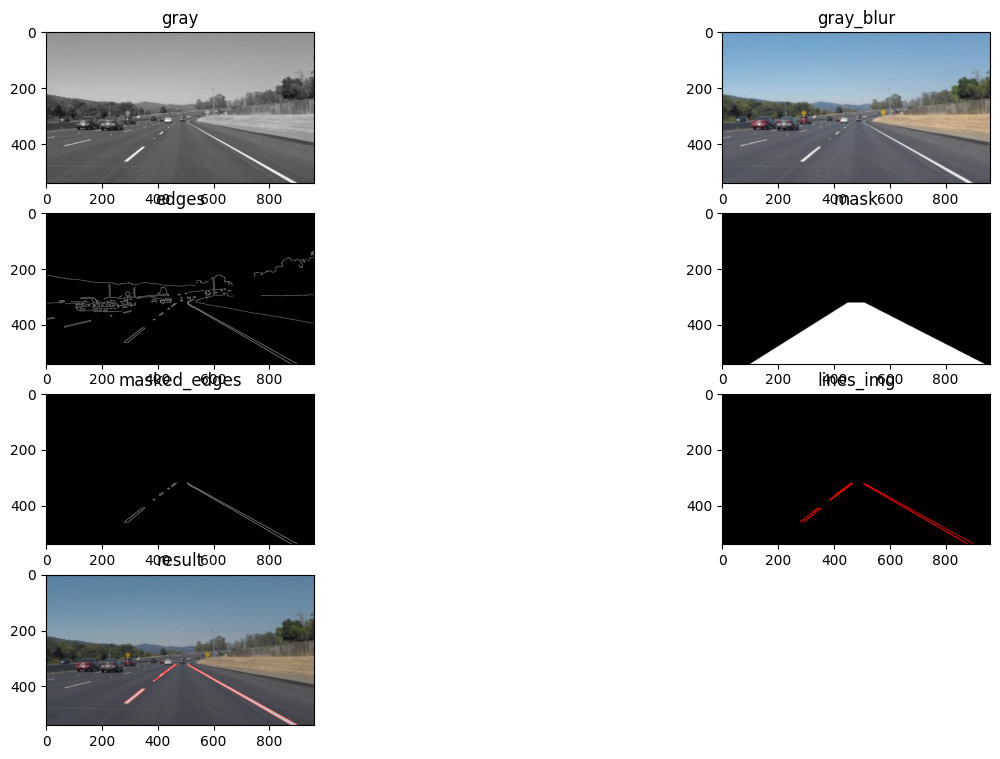

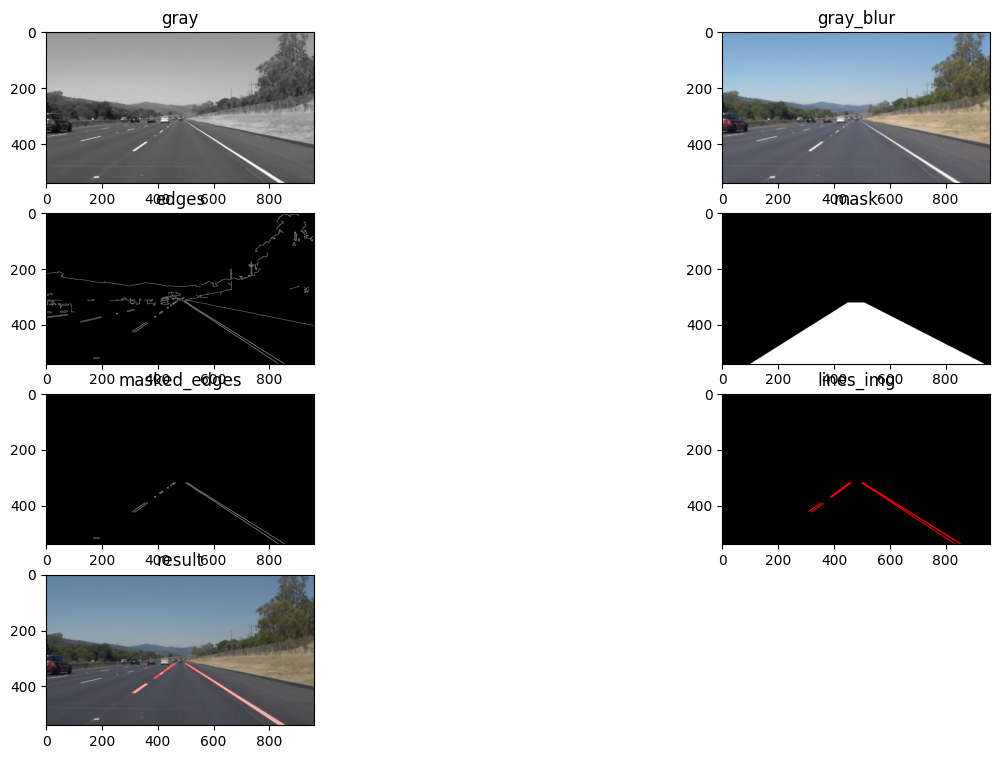

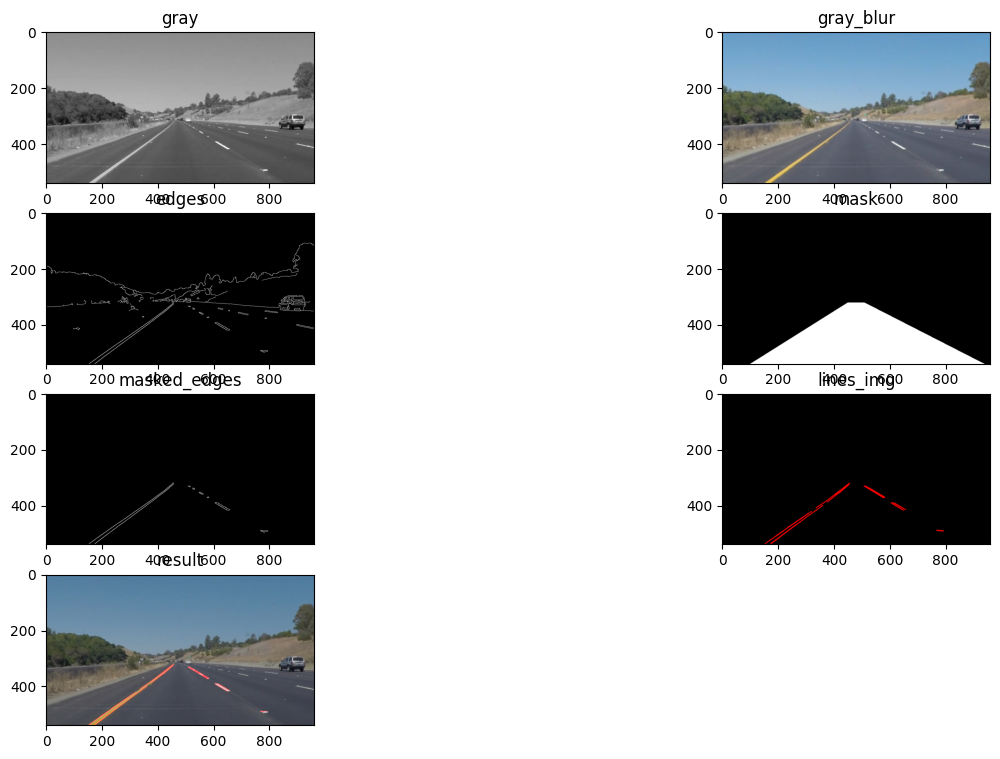

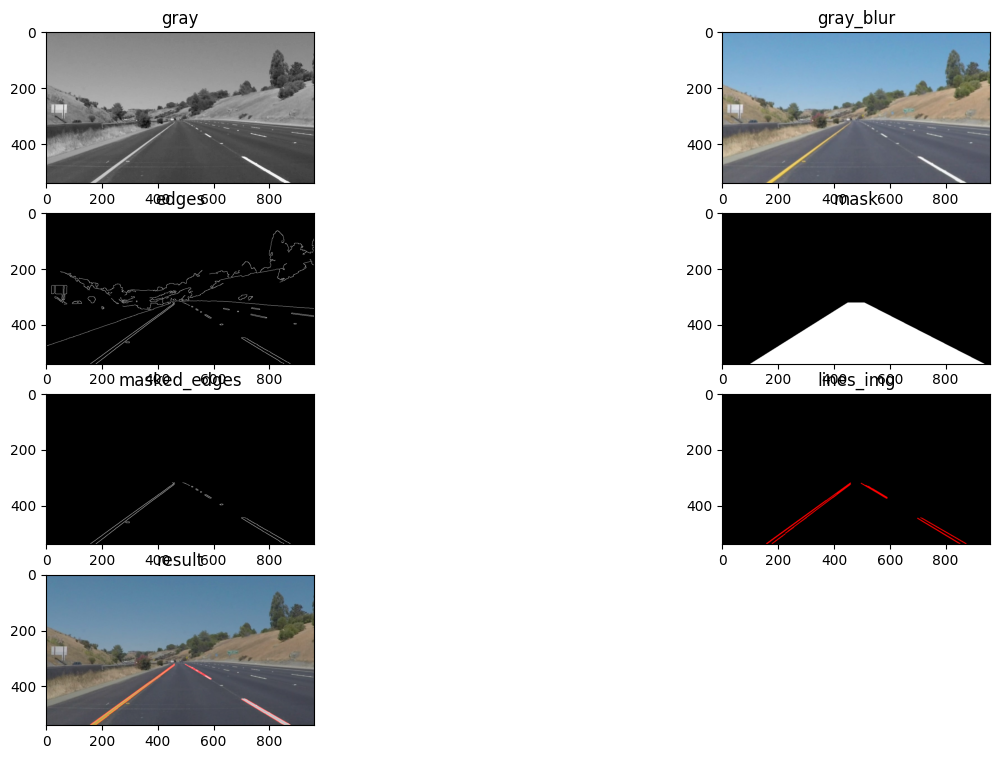

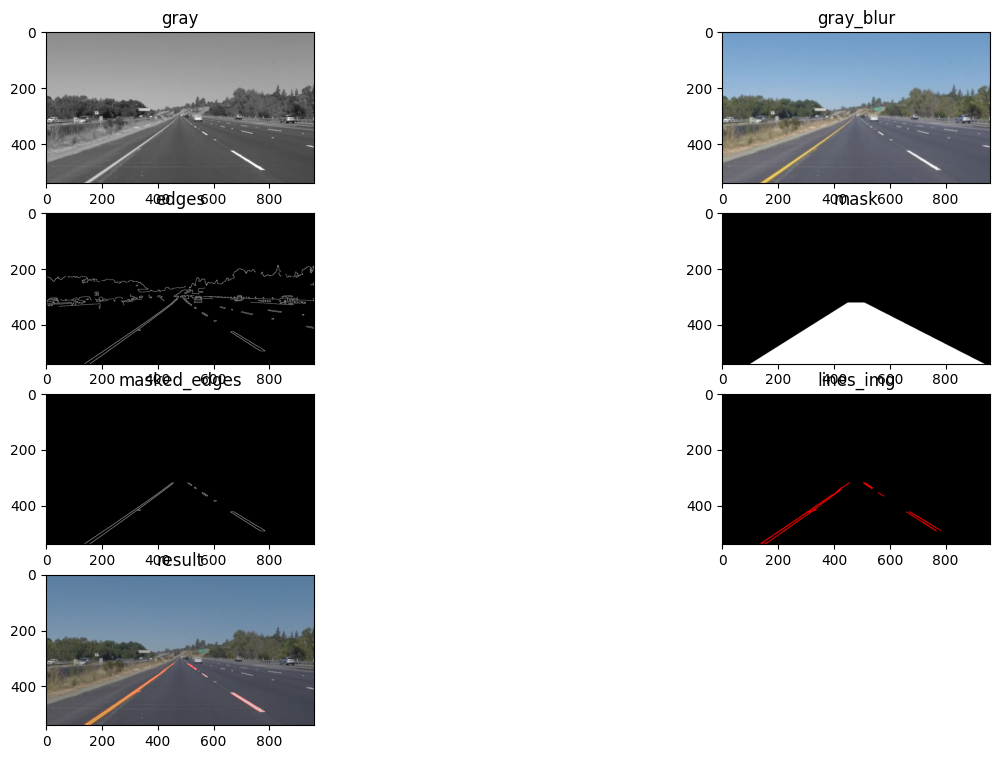

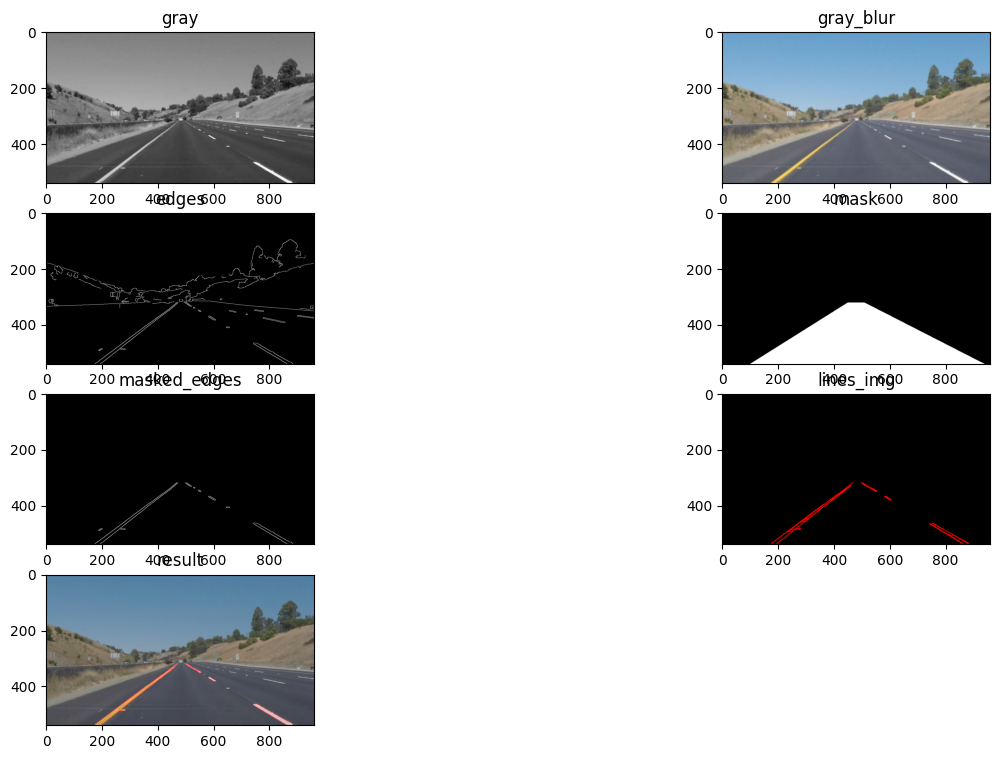

In [6]:
# Process all input images
for _, imgname in enumerate(image_names):
    img = mpimg.imread(os.path.join(images_ip_dir, imgname))
    result, _ = find_lane_lines(img, plot_images=True)
    mpimg.imsave(os.path.join(images_op_dir, imgname), result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
smoothing_win_size = 10
lines_history = []
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Find the lanes
    connected_lines = find_lane_lines(image, connected=True, plot_images=False,
                                      smoothing_kernel_size=5,canny_lo=50, canny_hi=150,
                                      hough_rho=2, hough_theta=1, hough_threshold=50, hough_min_line_len=20, hough_max_line_gap=20)
    lines_history.append(connected_lines)
    
    # Peform the smoothing routine
    if len(lines_history) > smoothing_win_size:
        connected_lines = perform_smoothing(lines_history)
    
    result = draw_connected_lane_lines(image, connected_lines)
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
videos_output_dirname = "test_videos_output/"
if not os.path.exists(videos_output_dirname):
    os.mkdir(videos_output_dirname)

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: total: 13.9 s
Wall time: 7.26 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
lines_history = []
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: total: 40.9 s
Wall time: 23.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))